In [4]:
import configparser
import sys
import os
import skymapper as skm
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import numpy as np
from plotting_utilities import get_versions,get_boundary_mask,put_survey_on_grid,clean_read,get_logger,add_colorbar_legend,initialize_gridspec_figure
import astropy.units as u
from datetime import datetime
from data_handler import load_covariance_chris,get_rp_chris,get_allowed_bins,get_number_of_source_bins,get_bins_mask,\
                        load_data_and_covariance_notomo,load_data_and_covariance_tomo,get_number_of_lens_bins,combine_datavectors,\
                        get_number_of_radial_bins,get_reference_datavector,get_scales_mask,get_deltasigma_amplitudes,\
                        get_reference_datavector_of_galtype,get_scales_mask_from_degrees,get_split_value,get_lens_bins
import matplotlib.gridspec as gridspec

from dsigma.jackknife import jackknife_resampling,jackknife_resampling_cross_covariance,compute_jackknife_fields,compress_jackknife_fields


sys.path.append('../')
from load_catalogues import get_lens_table,get_source_table,is_table_masked
from data_handler import get_allowed_bins

import pickle

from astropy.table import Table,join,hstack,vstack
script_name = 'splits'

from importlib import reload

from dsigma.stacking import excess_surface_density

In [2]:
config = configparser.ConfigParser()
config.read("/global/homes/s/sven/code/lensingWithoutBorders/plotting/config_plots.conf")

def replace_strings(x,old,new,copy=True):
    if(copy):
        from copy import deepcopy
        x = deepcopy(x)
    for i in range(len(old)):
        x = x.replace(str(old[i]),str(new[i]))
    return x


In [3]:
def get_precomputed_table(galaxy_type,source_survey,fpath_save,version,statistic,lens_bin,
                          savename_notomo="STAT_GALTYPE_zmin_ZMIN_zmax_ZMAX_blindBLIND_boost_BOOST",randoms=None,boost=True,split_by=None, split=None, n_splits=4):
    if source_survey is None:
        source_survey_str = ''
    else:
        source_survey_str = source_survey + '/'
    
    z_bins_lens = get_lens_bins(galaxy_type)
    


    table_l_split = Table.read(fpath_save + version + '/split_tables/' + source_survey_str + split_by + '/' + galaxy_type + f'_split_{split_by}_{split}_of_{n_splits}.fits')
    table_l_split.keep_columns(['TARGETID','z',split_by])
    if randoms is not None:
        table_r_split = Table.read(fpath_save + version + '/split_tables/' + source_survey_str + split_by + '/' + galaxy_type + f'_split_{split_by}_{split}_of_{n_splits}_randoms.fits')
        table_r_split.keep_columns(['RANDOM_TARGETID','z',split_by])

    mask_l = ((z_bins_lens[lens_bin] <= table_l_split['z']) &
            (table_l_split['z'] < z_bins_lens[lens_bin + 1]))

    table_l_part = table_l_split[mask_l]
    table_l_part.remove_column('z')
    if table_r_split is not None:
        mask_r = ((z_bins_lens[lens_bin] <= table_r_split['z']) &
                (table_r_split['z'] < z_bins_lens[lens_bin + 1]))
        table_r_part = table_r_split[mask_r]
        table_r_part.remove_column('z')

    else:
        table_r_part = None

    precomputed_tables_loadname = replace_strings(savename_notomo,
            ['STAT','GALTYPE','ZMIN','ZMAX','BLIND','BOOST'],
            [statistic,galaxy_type,z_bins_lens[lens_bin],z_bins_lens[lens_bin+1],
            'A',boost])

    precomputed_table_l = Table.read(fpath_save + version + '/precomputed_tables/' + source_survey + '/' + precomputed_tables_loadname + '_l.fits')
    with open("/global/cfs/cdirs/desicollab/science/c3/DESI-Lensing/lensing_measurements/v1.1/precomputed_tables/HSC/deltasigma_LRG_zmin_0.4_zmax_0.6_blindA_boost_True_meta.pkl","rb") as f:
        precomputed_tables_meta = pickle.load(f)
    precomputed_table_l.meta = precomputed_tables_meta
    
    if randoms is not None:
        precomputed_table_r = Table.read(fpath_save + version + '/precomputed_tables/' + source_survey + '/' + precomputed_tables_loadname + '_r.fits')
        precomputed_table_r.meta = precomputed_tables_meta
    else:
        precomputed_table_r = None
    table_l_part = join(table_l_part,precomputed_table_l,keys='TARGETID',join_type='left')
    if is_table_masked(table_l_part):
        print(f"Masked table_l in split {split} of {split_by} for lens_bin {lens_bin}!")
        print(f"Table_l_split masked: {is_table_masked(table_l_split)}, precomputed_table_l masked: {is_table_masked(precomputed_table_l)}")
        targetids_l_split = set(table_l_split['TARGETID'])
        targetids_precomputed_l = set(precomputed_table_l['TARGETID'])
        targetids_diff = targetids_l_split - targetids_precomputed_l
        print(f"Targetids in table_l_split but not in precomputed_table_l: {len(targetids_diff)}")
        print(f"Overlapping targetids: {len(join(table_l_split,precomputed_table_l,keys='TARGETID',join_type='inner'))}")
        print(f"Length of tables: {len(table_l_split)}, {len(precomputed_table_l)}")
        # sys.exit(-1)

    if randoms is not None:
        table_r_part = join(table_r_part,precomputed_table_r,keys='RANDOM_TARGETID',join_type='left')
        if is_table_masked(table_r_part):
            print(f"Masked table_r in split {split} of {split_by} for lens_bin {lens_bin}!")
            print(f"Table_r_split masked: {is_table_masked(table_r_split)}, precomputed_table_r masked: {is_table_masked(precomputed_table_r)}")
            # sys.exit(-1)
    return table_l_part,table_r_part



In [4]:
lens_bin = 0
tabs_l = []
tabs_r = []
for survey in ['HSC','KiDS']:
    for split_by in ['NTILE','STARDENS']:
        for split in range(4):
            tab_l_1,tab_r_1 = get_precomputed_table("BGS_BRIGHT",survey,
                                                    "/global/cfs/cdirs/desicollab/science/c3/DESI-Lensing/lensing_measurements/",
                                                    "v1.2","deltasigma",lens_bin,
                                                    "STAT_GALTYPE_zmin_ZMIN_zmax_ZMAX_blindBLIND_boost_BOOST",
                                                    True,True,split_by,split)
            tab_l_1.remove_columns(['field_jk',split_by])
            tab_r_1.remove_columns(['field_jk',split_by])

            # centers = compute_jackknife_fields(tab_l_1,100)
            # compute_jackknife_fields(tab_r_1,centers)
            tabs_l.append(tab_l_1)
            tabs_r.append(tab_r_1)
joint_tab_l = vstack(tabs_l)
joint_tab_r = vstack(tabs_r)
joint_tab_l.meta = tab_l_1.meta
joint_tab_r.meta = tab_r_1.meta
centers = compute_jackknife_fields(joint_tab_l,100)
_ = compute_jackknife_fields(joint_tab_r,centers)


In [5]:
is_table_masked(joint_tab_l),is_table_masked(joint_tab_r)

(True, True)

In [6]:
for col in joint_tab_l.colnames:
    print(col,getattr(joint_tab_l[col],'mask',None))
# any(getattr(col, 'mask', None) is not None for col in table.columns.values())

TARGETID None
z None
ra None
dec None
w_sys None
sum 1 None
sum w_ls None
sum w_ls e_t None
sum w_ls z_s None
sum w_ls e_t sigma_crit None
sum w_ls m None
sum w_ls (1 - e_rms^2) [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
sum w_ls A p(R_2=0.3) [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]]
sum w_ls z_l None
sum w_ls e_t sigma_crit f_bias [[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ 

In [7]:
ctabs_l = []
ctabs_r = []
counter_l = 0
counter_r = 0
for i in range(len(tabs_l)):
    ltab_l = len(tabs_l[i])
    ltab_r = len(tabs_r[i])
    ctabs_l.append(compress_jackknife_fields(joint_tab_l[counter_l:counter_l+ltab_l]))
    ctabs_r.append(compress_jackknife_fields(joint_tab_r[counter_r:counter_r+ltab_r]))
    counter_l += ltab_l
    counter_r += ltab_r

In [8]:
from importlib import reload
import dsigma.jackknife
import dsigma.stacking
reload(dsigma.jackknife)
reload(dsigma.stacking)
from dsigma.jackknife import jackknife_resampling,jackknife_resampling_cross_covariance,compute_jackknife_fields,compress_jackknife_fields

In [9]:
big_cov = jackknife_resampling_cross_covariance(excess_surface_density,ctabs_l,ctabs_r)
cov = jackknife_resampling(excess_surface_density,ctabs_l[0],ctabs_r[0])

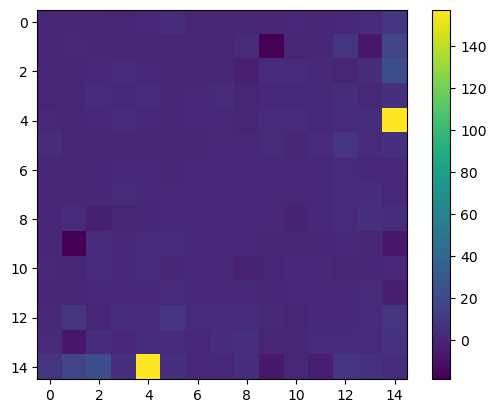

In [10]:
centers = compute_jackknife_fields(tabs_l[0],100)
_ = compute_jackknife_fields(tabs_r[0],centers)


cov = jackknife_resampling(excess_surface_density,compress_jackknife_fields(tabs_l[0]),compress_jackknife_fields(tabs_r[0]))
plt.imshow(big_cov[:15,:15]/cov)
plt.colorbar()

In [11]:
for i in range(len(big_cov)//15):
    cov = jackknife_resampling(excess_surface_density,ctabs_l[i],ctabs_r[i])
    assert np.allclose(big_cov[15*i:15*(i+1),15*i:15*(i+1)],cov)

AssertionError: 

Text(0.875, 1.05, 'STARDENS')

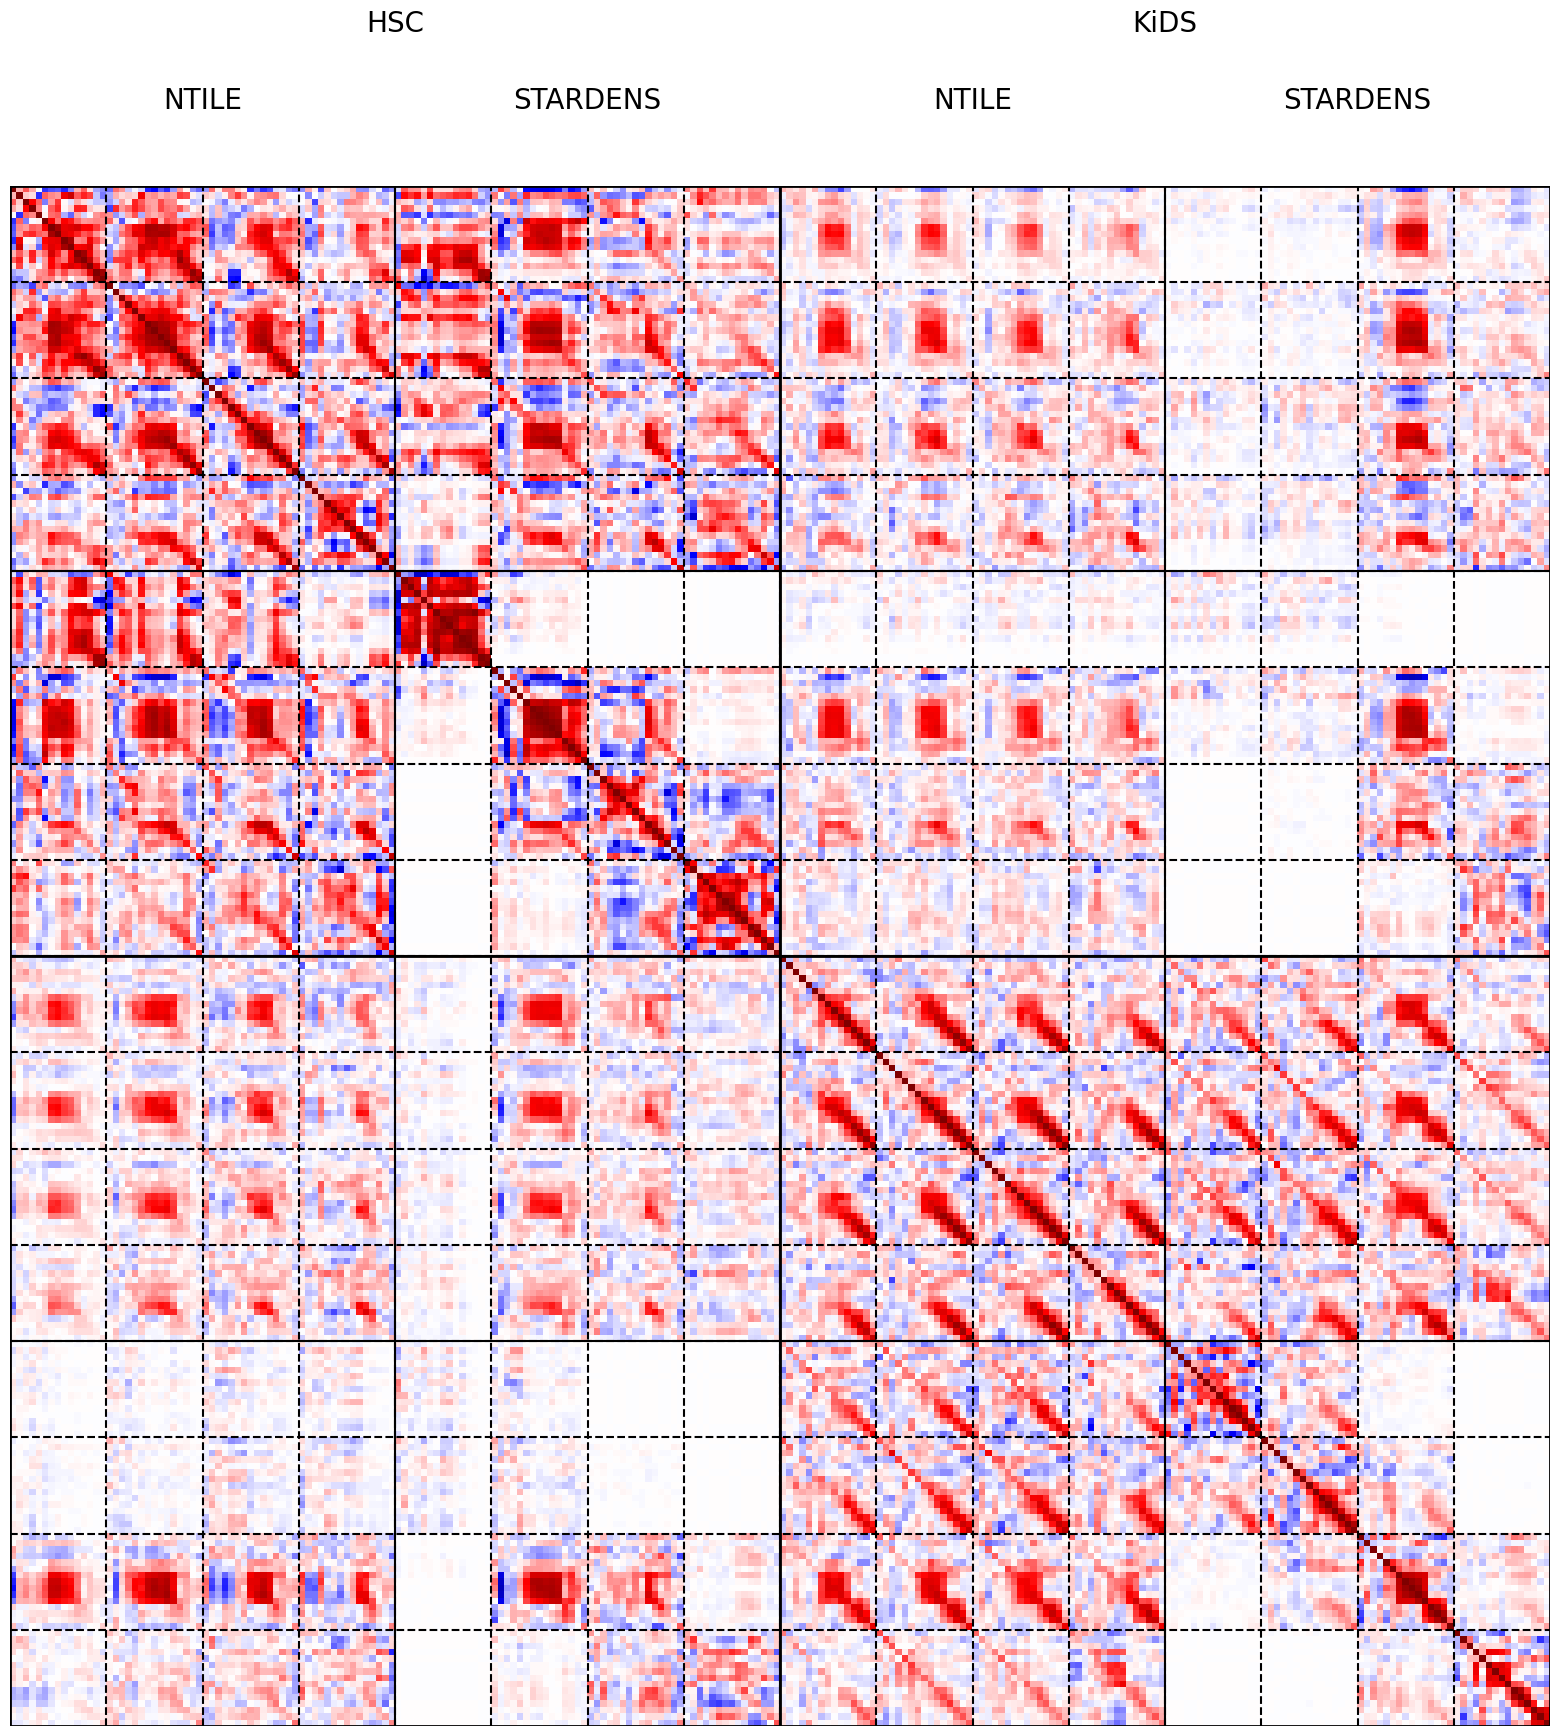

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(20,20))

plt.imshow(big_cov/np.sqrt(np.diag(big_cov)[:,None]*np.diag(big_cov)[None,:]),vmin=-1,vmax=1,cmap='seismic')
for i in range(len(big_cov)//15):
    plt.axhline(i*15-0.5,color='black',ls='--')
    plt.axvline(i*15-0.5,color='black',ls='--')
for i in range(len(big_cov)//(4*15)):
    plt.axhline(i*4*15-0.5,color='black',ls='-')
    plt.axvline(i*4*15-0.5,color='black',ls='-')
for i in range(len(big_cov)//(4*15*2)+1):
    plt.axhline(i*4*15*2-0.5,color='black',ls='-',lw=2)
    plt.axvline(i*4*15*2-0.5,color='black',ls='-',lw=2)

plt.axis('off')
ax.text(0.25,1.1,'HSC',transform=ax.transAxes,fontsize=20,horizontalalignment='center')
ax.text(0.5+0.25,1.1,'KiDS',transform=ax.transAxes,fontsize=20,horizontalalignment='center')
ax.text(0.25/2,1.05,'NTILE',transform=ax.transAxes,fontsize=20,horizontalalignment='center')
ax.text(0.25/2+0.25,1.05,'STARDENS',transform=ax.transAxes,fontsize=20,horizontalalignment='center')
ax.text(0.5+0.25/2,1.05,'NTILE',transform=ax.transAxes,fontsize=20,horizontalalignment='center')
ax.text(0.5+0.25/2+0.25,1.05,'STARDENS',transform=ax.transAxes,fontsize=20,horizontalalignment='center')

In [1]:
import sys
sys.path.append('../plotting/')
from data_handler import calculate_sigma_sys
from tqdm import tqdm,trange
import numpy as np
import matplotlib.pyplot as plt



In [8]:
sigma_sys_arr = np.zeros(1000)
sigma_sys_error_arr = np.zeros(1000)

sigma_sys_bayesian_arr = np.zeros(1000)
sigma_sys_bayesian_error_arr = np.zeros(1000)

sigma_sys_input_arr = np.zeros(1000)

for i in trange(1000):
    errors = np.random.uniform(0.1,0.5,10)
    sigma_sys_input = np.random.uniform(0,1)

    amplitudes = np.random.normal(1,np.sqrt(errors**2+sigma_sys_input**2))

    _,sigma_sys = calculate_sigma_sys(amplitudes,errors)
    _,sigma_sys_bayesian = calculate_sigma_sys(amplitudes,errors,method='bayesian')

    sigma_sys_arr[i] = sigma_sys[2]
    sigma_sys_bayesian_arr[i] = sigma_sys_bayesian[2]

    sigma_sys_error_arr[i] = (sigma_sys[3]-sigma_sys[1])/2
    sigma_sys_bayesian_error_arr[i] = (sigma_sys_bayesian[3]-sigma_sys_bayesian[1])/2

    sigma_sys_input_arr[i] = sigma_sys_input


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:08<00:00, 117.96it/s]


In [9]:
mask = np.isfinite(sigma_sys_arr)
print(np.sum(mask))
mask &= np.isfinite(sigma_sys_bayesian_arr)
print(np.sum(mask))
mask &= np.isfinite(sigma_sys_error_arr)
print(np.sum(mask))
mask &= np.isfinite(sigma_sys_bayesian_error_arr)
print(np.sum(mask))

sigma_sys_arr = sigma_sys_arr[mask]
sigma_sys_bayesian_arr = sigma_sys_bayesian_arr[mask]
sigma_sys_error_arr = sigma_sys_error_arr[mask]
sigma_sys_bayesian_error_arr = sigma_sys_bayesian_error_arr[mask]
sigma_sys_input_arr = sigma_sys_input_arr[mask]

print(np.mean((sigma_sys_input_arr-sigma_sys_arr)**2/sigma_sys_error_arr**2),np.mean((sigma_sys_input_arr-sigma_sys_bayesian_arr)**2/sigma_sys_bayesian_error_arr**2))
print(np.mean((sigma_sys_input_arr-sigma_sys_arr)**2),np.mean((sigma_sys_input_arr-sigma_sys_bayesian_arr)**2))


898
898
794
794
0.9489547045854713 6.3842598420602
0.03369096468082719 0.13911305215483724


[Text(0, 0, 'Frequentist'),
 Text(0, 1, 'Bayesian'),
 Text(0, 2, 'Bayesian brute')]

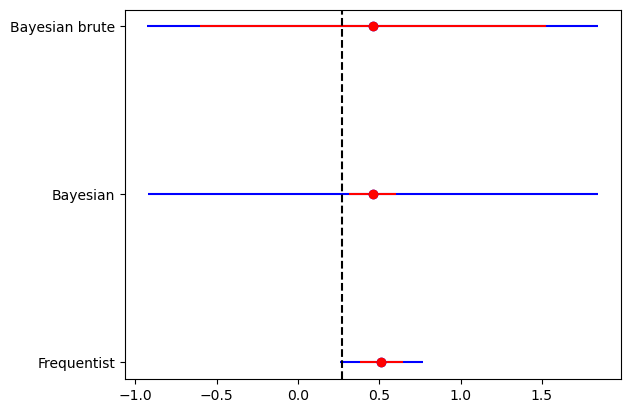

In [10]:
errors = np.random.uniform(0.1,0.5,10)
sigma_sys_input = np.random.uniform(0,1)

amplitudes = np.random.normal(1,np.sqrt(errors**2+sigma_sys_input**2))

_,sigma_sys = calculate_sigma_sys(amplitudes,errors)
_,sigma_sys_bayesian = calculate_sigma_sys(amplitudes,errors,method='bayesian')
_,sigma_sys_bayesian_brute = calculate_sigma_sys(amplitudes,errors,method='bayesian_brute')



plt.errorbar(sigma_sys[2],0,xerr=np.array(sigma_sys[2]-sigma_sys[0],sigma_sys[4]-sigma_sys[2]).reshape((1,1)),fmt='o',color='blue')
plt.errorbar(sigma_sys[2],0,xerr=np.array(sigma_sys[2]-sigma_sys[1],sigma_sys[3]-sigma_sys[2]).reshape((1,1)),fmt='o',label='Frequentist',color='red')

plt.errorbar(sigma_sys_bayesian[2],1,xerr=np.array(sigma_sys_bayesian[2]-sigma_sys_bayesian[0],sigma_sys_bayesian[4]-sigma_sys_bayesian[2]).reshape((1,1)),fmt='o',color='blue')
plt.errorbar(sigma_sys_bayesian[2],1,xerr=np.array(sigma_sys_bayesian[2]-sigma_sys_bayesian[1],sigma_sys_bayesian[3]-sigma_sys_bayesian[2]).reshape((1,1)),fmt='o',label='Bayesian',color='red')

plt.errorbar(sigma_sys_bayesian_brute[2],2,xerr=np.array(sigma_sys_bayesian_brute[2]-sigma_sys_bayesian_brute[0],sigma_sys_bayesian_brute[4]-sigma_sys_bayesian_brute[2]).reshape((1,1)),fmt='o',color='blue')
plt.errorbar(sigma_sys_bayesian_brute[2],2,xerr=np.array(sigma_sys_bayesian_brute[2]-sigma_sys_bayesian_brute[1],sigma_sys_bayesian_brute[3]-sigma_sys_bayesian_brute[2]).reshape((1,1)),fmt='o',label='Bayesian brute force',color='red')

plt.axvline(sigma_sys_input,color='black',ls='--')


ax = plt.gca()
ax.set_yticks([0,1,2])
ax.set_yticklabels(['Frequentist','Bayesian','Bayesian brute'])

Best-fit value: 0.186
1-sigma confidence interval: [0.158, 0.227]
0.6328745485916297
2-sigma confidence interval: [0.137, 0.289]
0.9282101200904309
3-sigma confidence interval: [0.121, 0.396]
0.9928315956071673


/tmp/ipykernel_244121/2583274456.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(alpha.pdf(x,a=a))
/global/homes/s/sven/.conda/envs/py38/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_244121/2583274456.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(alpha.pdf(x,a=a))
/tmp/ipykernel_244121/2583274456.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(alpha.pdf(x,a=a))
/global/homes/s/sven/.conda/envs/py38/lib/python3.8/site-packages/scipy/optimize/_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
/tmp/ipykernel_244121/2583274456.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(alpha.pdf(x,a=a))
/tmp/ipykernel_244121/2583274456.py:9: RuntimeWarning: divide by zero encountered in log
  return np.log(alpha.pdf(x,a=a))
/global/homes/s/sven/.conda/envs/py38/lib/p

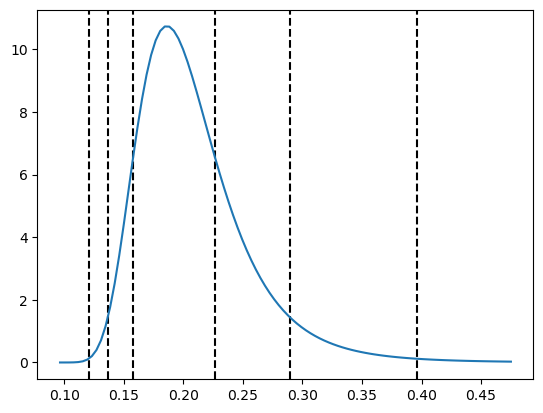

In [82]:
a = 5
scale = 2

from scipy.stats import gamma,alpha

def log_likelihood_function(x):
    # Define your likelihood function here
    # This is just an example, replace with your actual function
    return np.log(alpha.pdf(x,a=a))

# Example usage
for n_sigma in range(1,4):  # Change this to the desired number of standard deviations
    best_fit, lower_bound, upper_bound = find_best_fit_and_errors(log_likelihood_function, n_sigma)
    if n_sigma==1:
        print(f"Best-fit value: {best_fit:.3f}")
    print(f"{n_sigma}-sigma confidence interval: [{lower_bound:.3f}, {upper_bound:.3f}]")
    # from scipy.integrate import quad
    print(alpha.cdf(upper_bound,a=a)-alpha.cdf(lower_bound,a=a))
    plt.axvline(lower_bound,color='black',ls='--')
    plt.axvline(upper_bound,color='black',ls='--')

xarr = np.linspace(lower_bound*0.8,upper_bound*1.2,100)
plt.plot(xarr,alpha.pdf(xarr,a=a))

-1